In [2]:
# First import a bunch of useful stuff

import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle

from plotter import *

In [3]:
# This gives the integrated luminosity (the amount of data collected) for each year
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

In [4]:
# This dictionary gives the cross section (expected rate) of each simulated process
# Number of events of process P = integrated luminosity * cross section of process P
with open('xsec.json') as f:
  xs = json.load(f)
print(xs)

{'QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 32200, 'QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 6839, 'QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 1207, 'QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 120.1, 'QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 25.24, 'QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8': 20.23, 'QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madg

In [5]:
# This dictionary tells us how to group the simulated samples together sensibly
# For example, QCD is generated separately for different energies. Combine them
with open('pmap_mc.json') as f:
  pmap = json.load(f)
print(pmap)

{'ZH': ['ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8,'], 'WH': ['WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8'], 'ttH': ['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'], 'VBF': ['VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix'], 'ggF': ['GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8'], 'ggF-powheg': ['GluGluHToBB_M125_TuneCP5_13TeV-powheg-pythia8', 'GluGluHToBB_M125_13TeV_powheg_pythia8'], 'QCD': ['QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1500to2000_TuneC

In [6]:
# I like to run this for one year at a time
year = '2017'
outsum = processor.dict_accumulator()

In [7]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [8]:
# Number-counting significance as a function of the number of signal (s) and background (b) events
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [9]:
# The quickest option here: copy the pickle file from my area:
# /uscms/home/jennetd/nobackup/hbb-prod-modes/march-2021/vbf-ddbopt/pickles/templates.pkl

# To save time, I run the "load all files" step below once and pickle templates
# Then read in one histogram instead of loading all files each time
# First time I run with repickle=True. Else run with repickle=False
repickle=True

# Check if pickle exists, and don't re-create it if it does
picklename = 'pickles/templates.pkl'
if os.path.isfile(picklename):
    repickle=False

In [10]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
        
        # Skip data - we are dealing with only simulation right now
        if 'JetHT' in infiles.keys():
            continue
        if 'SingleMuon' in infiles.keys():
            continue
    
        filename = '/myeosdir/vbf-ddbopt/outfiles/'+year+'_'+str(n)+'.coffea'
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates1'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates1'].group('dataset', hist.Cat('process', 'Process'), pmap)
    
    # Select out the signal region
    templates = templates.integrate('region', 'signal')

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

Loaded file 1
Loaded file 2
Loaded file 3
Loaded file 4
Loaded file 5
Loaded file 6
Loaded file 7
Loaded file 8
Loaded file 9
Loaded file 10
Loaded file 11
Loaded file 12
Loaded file 13
Loaded file 14
Loaded file 15
Loaded file 16
Loaded file 17
Loaded file 18
Loaded file 19
Loaded file 20
Loaded file 21
Loaded file 22
Loaded file 23
Loaded file 24
Loaded file 25
Loaded file 26
Loaded file 27
Loaded file 28
Loaded file 29
Loaded file 30
Loaded file 31
Loaded file 32
Loaded file 33
Loaded file 34
Loaded file 35
Loaded file 36
Loaded file 37
Loaded file 38
Loaded file 39
Loaded file 40
Loaded file 41
Loaded file 42
Loaded file 43
Loaded file 44
Loaded file 45
Loaded file 46
Loaded file 47
Loaded file 48
Loaded file 49
Loaded file 50
Loaded file 51
Loaded file 52
Loaded file 53
Loaded file 54
Loaded file 55
Loaded file 56
Loaded file 57
Loaded file 58
Loaded file 59
Loaded file 60
Loaded file 61
Loaded file 62
Loaded file 63
Loaded file 64
Loaded file 65
Loaded file 66
Loaded file 67
Load

Loaded file 869
Loaded file 870
Loaded file 871
Loaded file 872
Loaded file 873
Loaded file 874
Loaded file 875
Loaded file 876
Loaded file 877
Loaded file 878
Loaded file 879
Loaded file 880
Loaded file 881
Loaded file 882
Loaded file 883
Loaded file 884
Loaded file 885
Loaded file 886
Loaded file 887
Loaded file 888
Loaded file 889
Loaded file 890
Loaded file 891
Loaded file 892
Loaded file 893
Loaded file 894
Loaded file 895
Loaded file 896
Loaded file 897
Loaded file 898
Loaded file 899
Loaded file 900
Loaded file 901
Loaded file 902
Loaded file 903
Loaded file 904
Loaded file 905
Loaded file 906
Loaded file 907
Loaded file 908
Loaded file 909
Loaded file 910
Loaded file 911
Loaded file 912
Loaded file 913
Loaded file 914
Loaded file 915
Loaded file 916
Loaded file 917
Loaded file 918
Loaded file 919
Loaded file 920
Loaded file 921
Loaded file 922
Loaded file 923
Loaded file 924
Loaded file 925
Loaded file 926
Loaded file 927
Loaded file 928
Loaded file 929
Loaded file 930
Loaded f

Loaded file 1785
Loaded file 1786
Loaded file 1787
Loaded file 1788
Loaded file 1789
Loaded file 1790
Loaded file 1791
Loaded file 1792
Loaded file 1793
Loaded file 1794
Loaded file 1795
Loaded file 1796
Loaded file 1797
Loaded file 1798
Loaded file 1799
Loaded file 1800
Loaded file 1801
Loaded file 1802
Loaded file 1803
Loaded file 1804
Loaded file 1805
Loaded file 1806
Loaded file 1807
Loaded file 1808
Loaded file 1809
Loaded file 1810
Loaded file 1811
Loaded file 1812
Loaded file 1813
Loaded file 1814
Loaded file 1815
Loaded file 1816
Loaded file 1817
Loaded file 1818
Loaded file 1819
Loaded file 1820
Loaded file 1821
Loaded file 1822
Loaded file 1823
Loaded file 1824
Loaded file 1825
Loaded file 1826
Loaded file 1827
Loaded file 1828
Loaded file 1829
Loaded file 1830
Loaded file 1831
Loaded file 1832
Loaded file 1833
Loaded file 1834
Loaded file 1835
Loaded file 1836
Loaded file 1837
Loaded file 1838
Loaded file 1839
Loaded file 1840
Loaded file 1841
Loaded file 1842
Loaded file 18

Loaded file 2267
Loaded file 2268
Loaded file 2269
Loaded file 2270
Loaded file 2271
Loaded file 2272
Loaded file 2273
Loaded file 2274
Loaded file 2275
Loaded file 2276
Loaded file 2277
Loaded file 2278
Loaded file 2279
Loaded file 2280
Loaded file 2281
Loaded file 2282
Loaded file 2283
Loaded file 2284
Loaded file 2285
Loaded file 2286
Loaded file 2287
Loaded file 2288
Loaded file 2289
Loaded file 2290
Loaded file 2291
Loaded file 2292
Loaded file 2293
Loaded file 2294
Loaded file 2295
Loaded file 2296
Loaded file 2297
Loaded file 2298
Loaded file 2299
Loaded file 2300
Loaded file 2301
Loaded file 2302
Loaded file 2303
Loaded file 2304
Loaded file 2305
Loaded file 2306
Loaded file 2307
Loaded file 2308
Loaded file 2309
Loaded file 2310
Loaded file 2311
Loaded file 2312
Loaded file 2313
Loaded file 2314
Loaded file 2315
Loaded file 2316
Loaded file 2317
Loaded file 2318
Loaded file 2319
Loaded file 2320
Loaded file 2321
Loaded file 2322
Loaded file 2323
Loaded file 2324
Loaded file 23

Loaded file 2746
Loaded file 2747
Loaded file 2748
Loaded file 2749
Loaded file 2750
Loaded file 2751
Loaded file 2752
Loaded file 2753
Loaded file 2754
Loaded file 2755
Loaded file 2756
Loaded file 2757
Loaded file 2758
Loaded file 2759
Loaded file 2760
Loaded file 2761
Loaded file 2762
Loaded file 2763
Loaded file 2764
Loaded file 2765
Loaded file 2766
Loaded file 2767
Loaded file 2768
Loaded file 2769
Loaded file 2770
Loaded file 2771
Loaded file 2772
Loaded file 2773
Loaded file 2774
Loaded file 2775
Loaded file 2776
Loaded file 2777
Loaded file 2778
Loaded file 2779
Loaded file 2780
Loaded file 2781
Loaded file 2782
Loaded file 2783
Loaded file 2784
Loaded file 2785
Loaded file 2786
Loaded file 2787
Loaded file 2788
Loaded file 2789
Loaded file 2790
Loaded file 2791
Loaded file 2792
Loaded file 2793
Loaded file 2794
Loaded file 2795
Loaded file 2796
Loaded file 2797
Loaded file 2798
Loaded file 2799
Loaded file 2800
Loaded file 2801
Loaded file 2802
Loaded file 2803
Loaded file 28

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fb652a8c7c0>
  warnings.warn(


In [11]:
# Read the histogram from the pickle file
templates = pickle.load(open(picklename,'rb'))

In [12]:
# Sum over all bins and print the total number of events per process
templates.sum('msd1','deta','mjj','ddb1').values()

{('ZH',): 14.499776537922521,
 ('WH',): 11.532616177845286,
 ('ttH',): 21.93820561446167,
 ('VBF',): 32.657991137640366,
 ('ggF',): 76.851075716208,
 ('ggF-powheg',): 156.59744103535937,
 ('QCD',): 4008994.443499559,
 ('VV',): 1288.3117120342106,
 ('Wjets',): 91422.54090350348,
 ('Zjets',): 43273.63568807628,
 ('ttbar',): 19757.769359435322,
 ('singlet',): 3109.7628093855697}

In [13]:
# Sum the histogram over all but one variable
x = templates.sum('deta','mjj','ddb1')

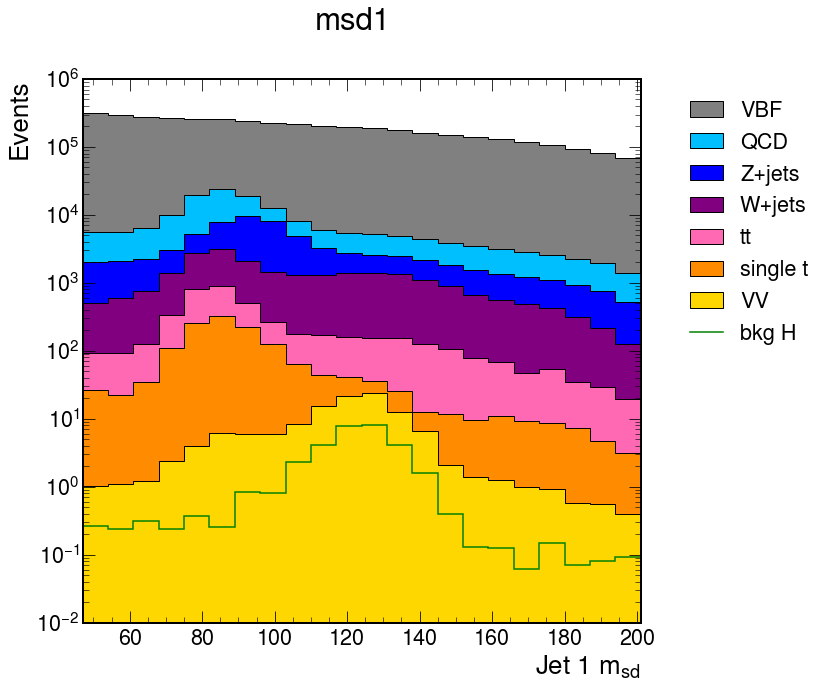

In [14]:
# draw the plot of soft drop mass
# NB: the Higgs mass window is 110-138 GeV
plot_mconly_vbf(x,'msd1','msd1')

In [15]:
# Select out events in the Higgs mass window
templates_window=templates.integrate('msd1',int_range=slice(mbb_min,mbb_max))

In [16]:
# Apply a cut
templates_cut = templates_window.integrate('deta',int_range=slice(3.5,7)).integrate('mjj',int_range=slice(1000,4000))

# Print the number of events passing the cut per process
templates_cut.sum('ddb1').values()

{('ZH',): 0.09187409654016773,
 ('WH',): 0.3463945881723239,
 ('ttH',): 0.2006407373960016,
 ('VBF',): 11.7582725651735,
 ('ggF',): 2.9171278960863547,
 ('ggF-powheg',): 6.094746562749274,
 ('QCD',): 32967.4030099923,
 ('VV',): 1.5169551387537428,
 ('Wjets',): 406.1350346849452,
 ('Zjets',): 229.57684027542973,
 ('ttbar',): 173.8784566530494,
 ('singlet',): 31.191699028372117}

In [20]:
sr = templates_cut.integrate('ddb1',int_range=slice(0.89,1)).values()

# Get the number of signal and background events
s = sr[('VBF',)] 
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]

# Print the significance
print(significance(s,b))
# Note: this only makes sense in the mass window of Higgs

0.35340991217397166
